# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [2]:
filename=filename="SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [3]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [4]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [5]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

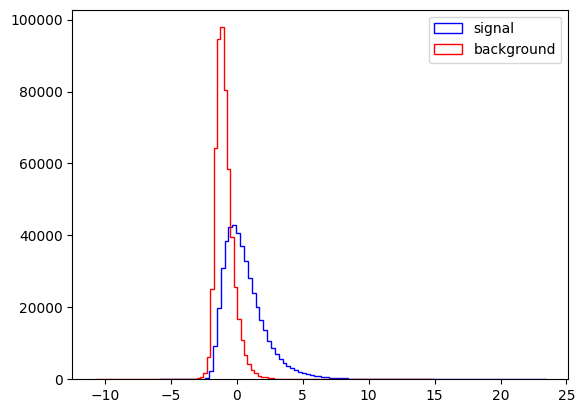

In [6]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

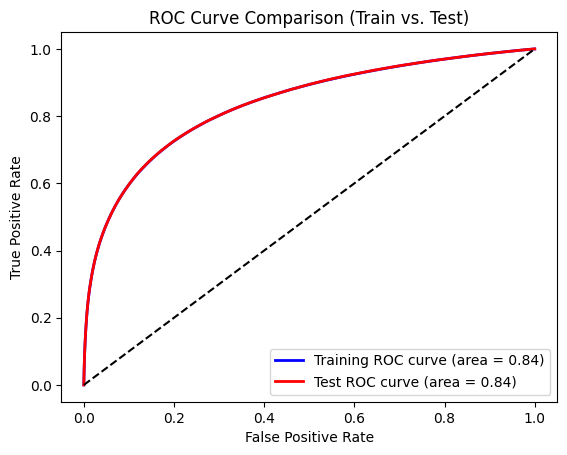

In [8]:
from sklearn.metrics import roc_curve, auc
train_scores = Fisher.decision_function(X_Train)
test_scores = Fisher.decision_function(X_Test)

fpr_train, tpr_train, _ = roc_curve(y_Train, train_scores)
fpr_test, tpr_test, _ = roc_curve(y_Test, test_scores)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Train vs. Test)')
plt.legend(loc='lower right')
plt.show()

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

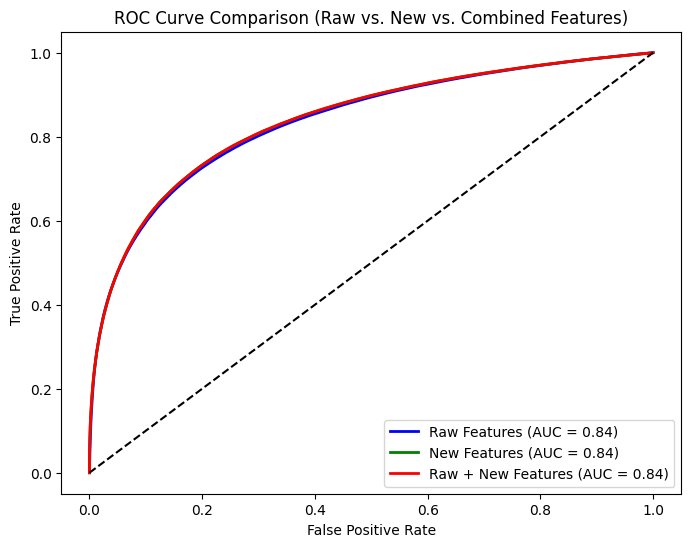

In [9]:
new_features_train = X_Train.copy()
new_features_test = X_Test.copy()

new_features_train['l_1_pT_squared'] = X_Train['l_1_pT']**2
new_features_test['l_1_pT_squared'] = X_Test['l_1_pT']**2

X_Train_combined = pd.concat([X_Train, new_features_train[['l_1_pT_squared']]], axis=1)
X_Test_combined = pd.concat([X_Test, new_features_test[['l_1_pT_squared']]], axis=1)

Fisher.fit(X_Train, y_Train)
train_scores_raw = Fisher.decision_function(X_Train)
test_scores_raw = Fisher.decision_function(X_Test)

Fisher.fit(new_features_train, y_Train)
train_scores_new = Fisher.decision_function(new_features_train)
test_scores_new = Fisher.decision_function(new_features_test)

Fisher.fit(X_Train_combined, y_Train)
train_scores_combined = Fisher.decision_function(X_Train_combined)
test_scores_combined = Fisher.decision_function(X_Test_combined)

fpr_raw, tpr_raw, _ = roc_curve(y_Train, train_scores_raw)
fpr_test_raw, tpr_test_raw, _ = roc_curve(y_Test, test_scores_raw)
roc_auc_raw = auc(fpr_raw, tpr_raw)

fpr_new, tpr_new, _ = roc_curve(y_Train, train_scores_new)
fpr_test_new, tpr_test_new, _ = roc_curve(y_Test, test_scores_new)
roc_auc_new = auc(fpr_new, tpr_new)

fpr_combined, tpr_combined, _ = roc_curve(y_Train, train_scores_combined)
fpr_test_combined, tpr_test_combined, _ = roc_curve(y_Test, test_scores_combined)
roc_auc_combined = auc(fpr_combined, tpr_combined)

plt.figure(figsize=(8, 6))
plt.plot(fpr_test_raw, tpr_test_raw, color='blue', lw=2, label=f'Raw Features (AUC = {roc_auc_raw:.2f})')
plt.plot(fpr_test_new, tpr_test_new, color='green', lw=2, label=f'New Features (AUC = {roc_auc_new:.2f})')
plt.plot(fpr_test_combined, tpr_test_combined, color='red', lw=2, label=f'Raw + New Features (AUC = {roc_auc_combined:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Raw vs. New vs. Combined Features)')
plt.legend(loc='lower right')
plt.show()

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    
    if hasattr(classifier, "decision_function"):
        train_scores = classifier.decision_function(X_train)
        test_scores = classifier.decision_function(X_test)
    else:
        train_scores = classifier.predict_proba(X_train)[:, 1]
        test_scores = classifier.predict_proba(X_test)[:, 1]
    
    fpr_train, tpr_train, _ = roc_curve(y_train, train_scores)
    fpr_test, tpr_test, _ = roc_curve(y_test, test_scores)
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)
    
    return fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test

def compute_significance(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    S = tpr * sum(y_true)
    B = fpr * (len(y_true) - sum(y_true))  
    
    significance = np.where((S + B) > 0, S / np.sqrt(S + B), 0)
    max_significance = np.max(significance)
    best_threshold = thresholds[np.argmax(significance)]
    
    return max_significance, best_threshold

classifiers = {
    "SVM": SVC(probability=True, kernel='linear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=6)
}

results = {}

for name, clf in classifiers.items():
    print(f"\nEvaluating {name}...")
    try:
        fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test = evaluate_classifier(
            clf, X_Train, y_Train, X_Test, y_Test
        )
        
        if hasattr(clf, "predict_proba"):
            y_scores = clf.predict_proba(X_Test)[:, 1]
        elif hasattr(clf, "decision_function"):
            y_scores = clf.decision_function(X_Test)
        else:
            raise ValueError(f"Classifier {name} does not support predict_proba or decision_function.")
        
        max_significance, best_threshold = compute_significance(y_Test, y_scores)
        
        results[name] = {
            "AUC (Train)": auc_train,
            "AUC (Test)": auc_test,
            "Max Significance": max_significance,
            "Best Threshold": best_threshold
        }
        print(f"{name} completed successfully.")
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

print("\nFinal Results:")
for name, metrics in results.items():
    print(f"\n{name} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")


Evaluating SVM...


### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
import pandas as pd

def evaluate_metrics(classifier, X_train, y_train, X_test, y_test):
    # Train the classifier
    classifier.fit(X_train, y_train)
    
    if hasattr(classifier, "predict_proba"):
        y_scores = classifier.predict_proba(X_test)[:, 1]
    elif hasattr(classifier, "decision_function"):
        y_scores = classifier.decision_function(X_test)
    else:
        raise ValueError("Classifier must support predict_proba or decision_function.")
    
    y_pred = (y_scores >= 0.5).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    max_significance, best_threshold = compute_significance(y_test, y_scores)
    
    return {
        "TPR (Recall)": recall,
        "FPR": fpr[1] if len(fpr) > 1 else 0,  
        "ROC AUC": roc_auc,
        "Precision": precision,
        "F1 Score": f1,
        "Accuracy": accuracy,
        "Max Significance": max_significance,
        "Best Threshold": best_threshold
    }

selected_classifier = RandomForestClassifier(n_estimators=100, random_state=92) 
metrics = evaluate_metrics(selected_classifier, X_Train, y_Train, X_Test, y_Test)

metrics_df = pd.DataFrame([metrics])

print("\nMetrics Table:")